In [1]:
import numpy as np
from tqdm import tqdm
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from skimage import io, feature, filters, transform
from skimage.filters import threshold_otsu
from scipy.ndimage import distance_transform_edt
from skimage.measure import label
from skimage.segmentation import watershed
from skimage.measure import find_contours

from utils import *

In [2]:
def compute_largest_eigenvalue(image, sigma=1, pad_width=10):
    nuclear = (image!=0).astype(np.uint8)
    nuclear_scaled = transform.rescale(nuclear, (500-pad_width*2)/500)
    nuclear_padded = np.pad(nuclear_scaled, pad_width=pad_width, mode='constant', constant_values=0)

    # 计算结构张量
    result = feature.structure_tensor(image, sigma=sigma, order='rc')
    # 从结构张量中获取特征值
    eigenvalues = feature.structure_tensor_eigenvalues(result)
    # 返回每个点的最大特征值
    return np.max(eigenvalues, axis=0)*nuclear_padded

# 使用distance_transform_edt
def apply_h_watershed(image, min_distance=5):
    print(threshold_otsu(image))
    print(threshold_otsu(image[image>0]))
    mask = image > threshold_otsu(image[image>0])
    # 计算距离变换
    distance = distance_transform_edt(mask)
    # 在距离图中找到峰值
    local_maxi = feature.peak_local_max(distance, min_distance=min_distance, labels=mask)
    # 将峰值的坐标转换为标记矩阵
    if len(local_maxi)<=255:
        markers = np.zeros_like(image, dtype=np.uint8)
    else:
#         print("len(local_maxi)>255")
        markers = np.zeros_like(image, dtype=np.int32)
    for i, (row, col) in enumerate(local_maxi):
        markers[row, col] = i + 1
    # 执行分水岭分割
    labels_ws = watershed(-distance, markers, mask=mask)
    return labels_ws

In [59]:
ctrl_type = "RETT"
rett_type = "HPS3042"
chip_type = "H3K27ac"
home_path = "/groups/4/gaa50089/acd13264yb/Rettsyndrome/Classification"
image_path = f"{ctrl_type}_{rett_type}_{chip_type}"

5.0351344882435855e-05
7.000065020241081e-05
Calculate_quantitative_metrics:
chromatin_num: 110
nuclear_area: 28537
chromatin_area: 11.409090909090908
RCA-S: 0.04397799348214598
RCA-M: 0.0003997999407467817
nuclear_intensity: 32.18421698146266
chromatin_intensity: 40.89878415006786
RCI-S: 139.78485973726512
RCI-M: 1.2707714521569557


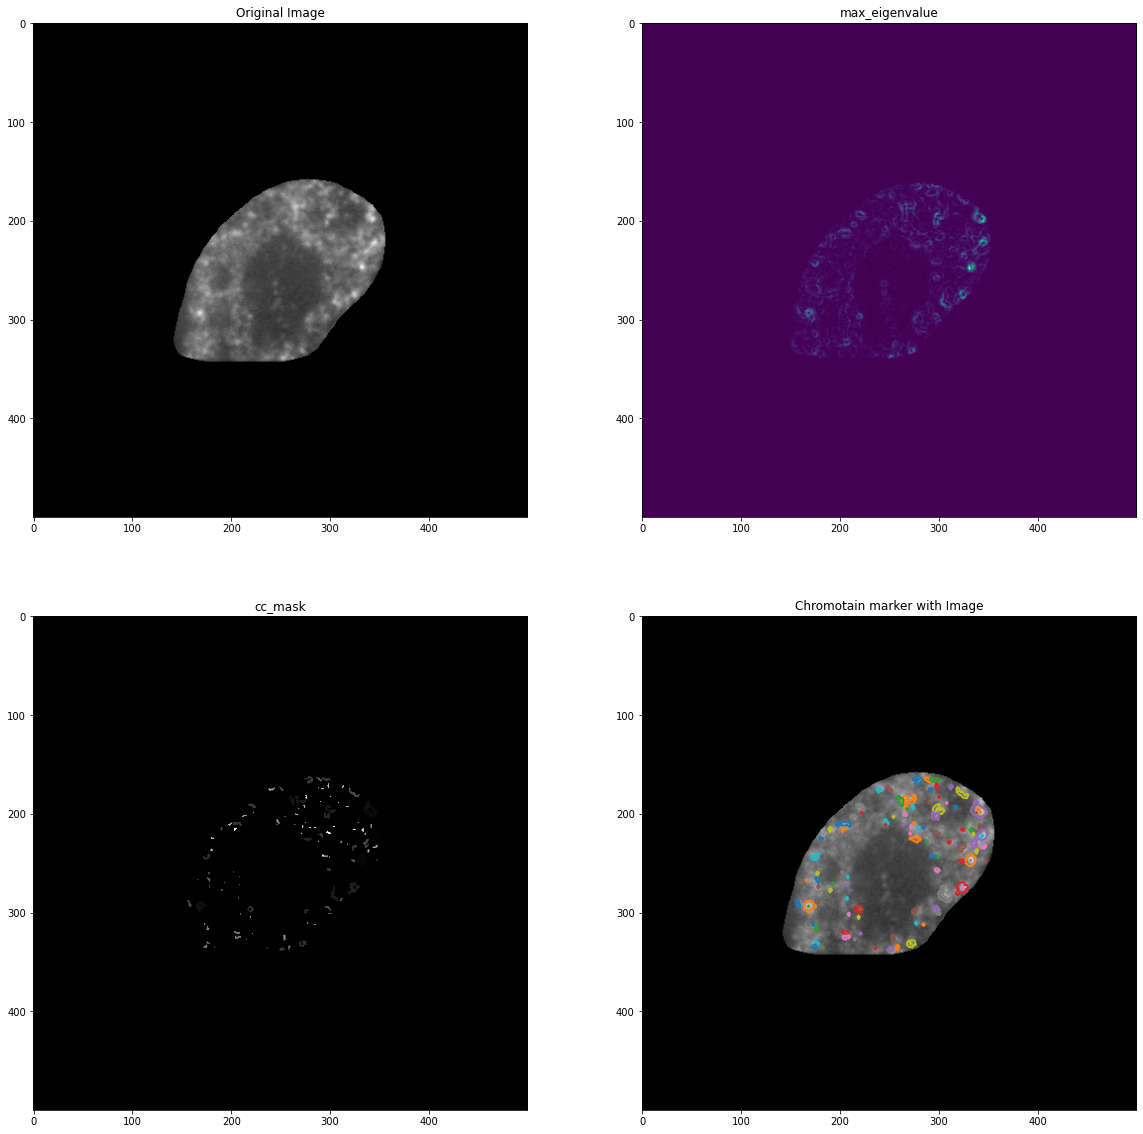

In [110]:
ctrl_type = "RETT"
rett_type = "HPS9999"
chip_type = "H3K27ac"
image_path = f"{ctrl_type}_{rett_type}_{chip_type}"


image = np.load(f"{home_path}/Datasets/{image_path}.npy", allow_pickle=True)[5]
image = image[:,:,0]
plt.figure(figsize=(20,20))
plt.subplot(2,2,1)
plt.title("Original Image")
plt.imshow(image, cmap='gray')

# Extract particle (Heterochromatin)
max_eigenvalue = compute_largest_eigenvalue(image, sigma=0, pad_width=10)
plt.subplot(2,2,2)
plt.title("max_eigenvalue")
plt.imshow(max_eigenvalue)
cc_mask = apply_h_watershed(max_eigenvalue, min_distance=5)
plt.subplot(2,2,3)
plt.title("cc_mask")
plt.imshow(cc_mask, cmap='gray')

# Metrics particle (Heterochromatin)
metrics = calculate_quantitative_metrics(image, cc_mask)
print("Calculate_quantitative_metrics:")
for key, value in metrics.items():
    print(f"{key}: {value}")

cc_contours = find_contours(cc_mask, level=0.5)
plt.subplot(2,2,4)
plt.title("Chromotain marker with Image")
plt.imshow(image, cmap='gray')
for contour in cc_contours:
    plt.plot(contour[:, 1], contour[:, 0], linewidth=2)
plt.show()

1.2917825723138162e-05
1.882264432678678e-05
Calculate_quantitative_metrics:
chromatin_num: 68
nuclear_area: 31153
chromatin_area: 28.558823529411764
RCA-S: 0.062337495586299876
RCA-M: 0.0009167278762691157
nuclear_intensity: 29.479696979424133
chromatin_intensity: 38.909056537350146
RCI-S: 89.75044235992327
RCI-M: 1.31985944646946


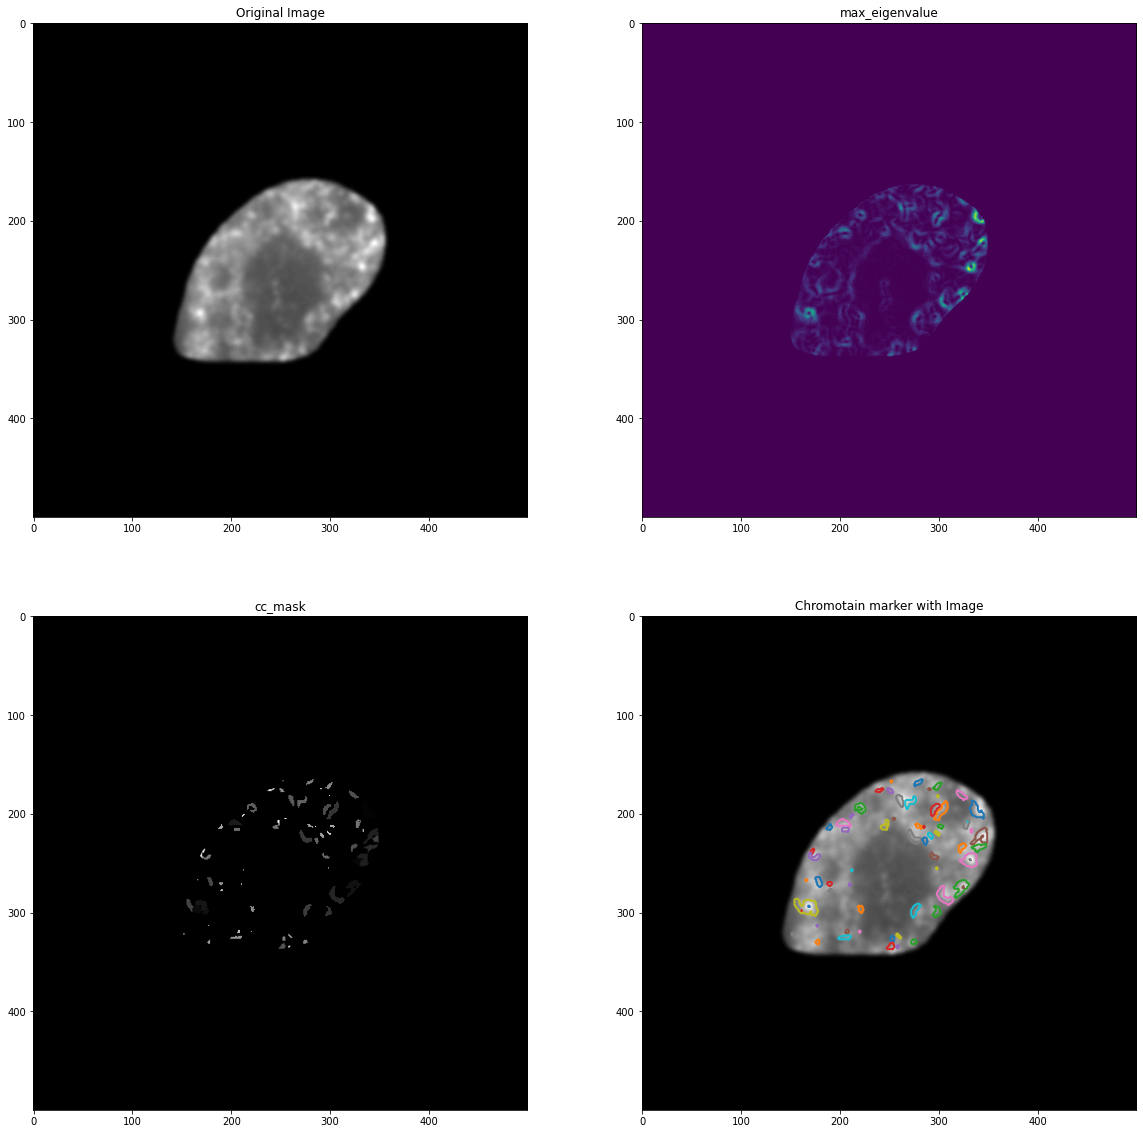

In [61]:
imagelr = np.load(f"{home_path}/Datasets_LR/{image_path}.npy", allow_pickle=True)[5]
imagelr = imagelr[:,:,0]
plt.figure(figsize=(20,20))
plt.subplot(2,2,1)
plt.title("Original Image")
plt.imshow(imagelr, cmap='gray')

# Extract particle (Heterochromatin)
max_eigenvaluelr = compute_largest_eigenvalue(imagelr, sigma=0, pad_width=25)
plt.subplot(2,2,2)
plt.title("max_eigenvalue")
plt.imshow(max_eigenvaluelr)
cc_masklr = apply_h_watershed(max_eigenvaluelr, min_distance=5)
plt.subplot(2,2,3)
plt.title("cc_mask")
plt.imshow(cc_masklr, cmap='gray')

# Metrics particle (Heterochromatin)
metrics = calculate_quantitative_metrics(imagelr, cc_masklr)
print("Calculate_quantitative_metrics:")
for key, value in metrics.items():
    print(f"{key}: {value}")

cc_contourslr = find_contours(cc_masklr, level=0.5)
plt.subplot(2,2,4)
plt.title("Chromotain marker with Image")
plt.imshow(imagelr, cmap='gray')
for contour in cc_contourslr:
    plt.plot(contour[:, 1], contour[:, 0], linewidth=2)
plt.show()

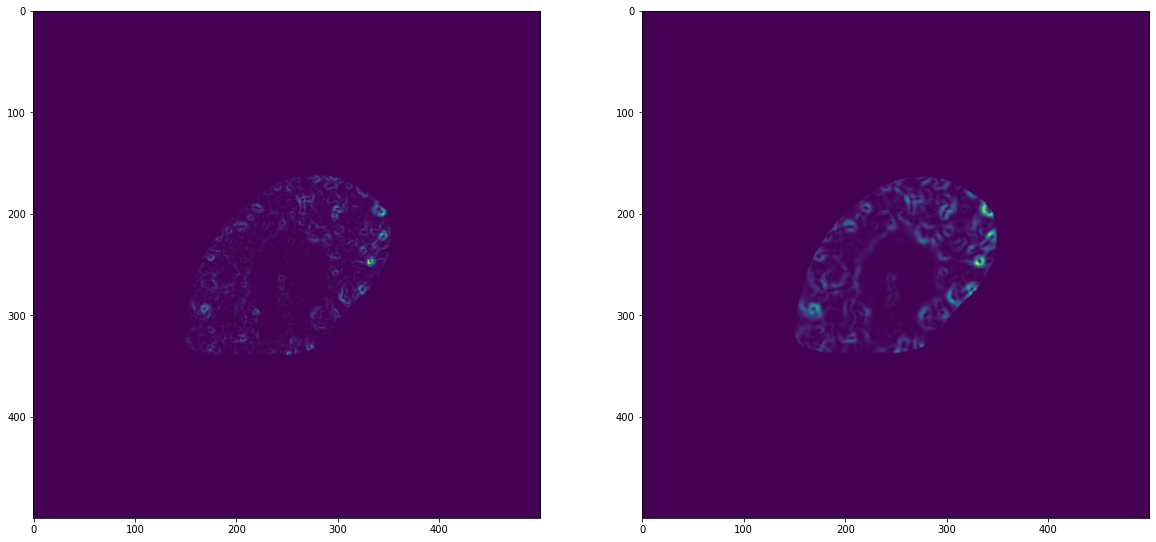

In [62]:
plt.figure(figsize=(20,20))
plt.subplot(1,2,1)
plt.imshow(max_eigenvalue)
plt.subplot(1,2,2)
plt.imshow(max_eigenvaluelr)

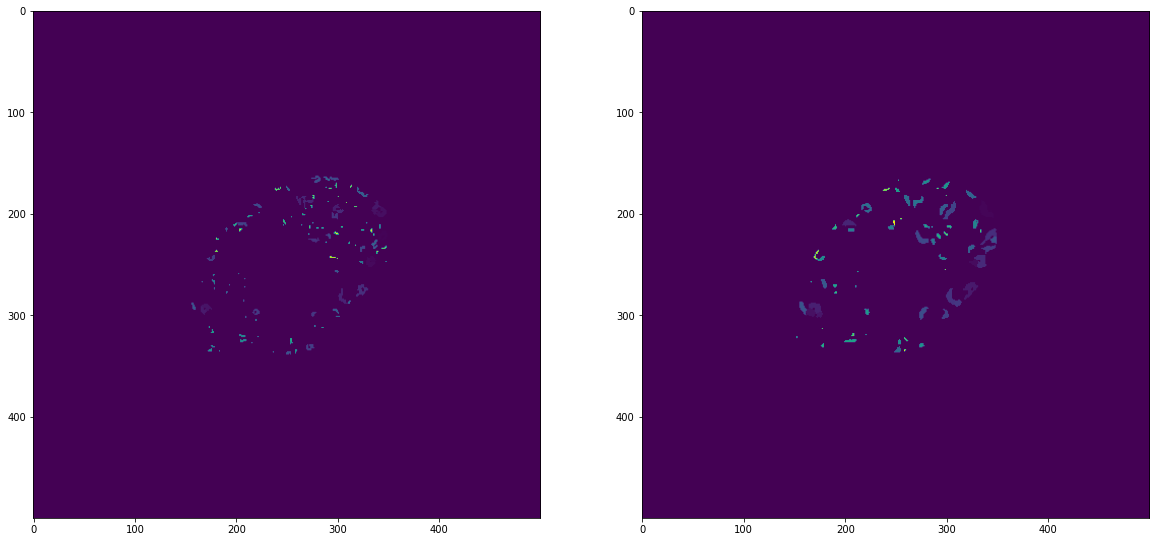

In [63]:
plt.figure(figsize=(20,20))
plt.subplot(1,2,1)
plt.imshow(cc_mask*int(255/cc_mask.max()))
plt.subplot(1,2,2)
plt.imshow(cc_masklr*int(255/cc_masklr.max()))

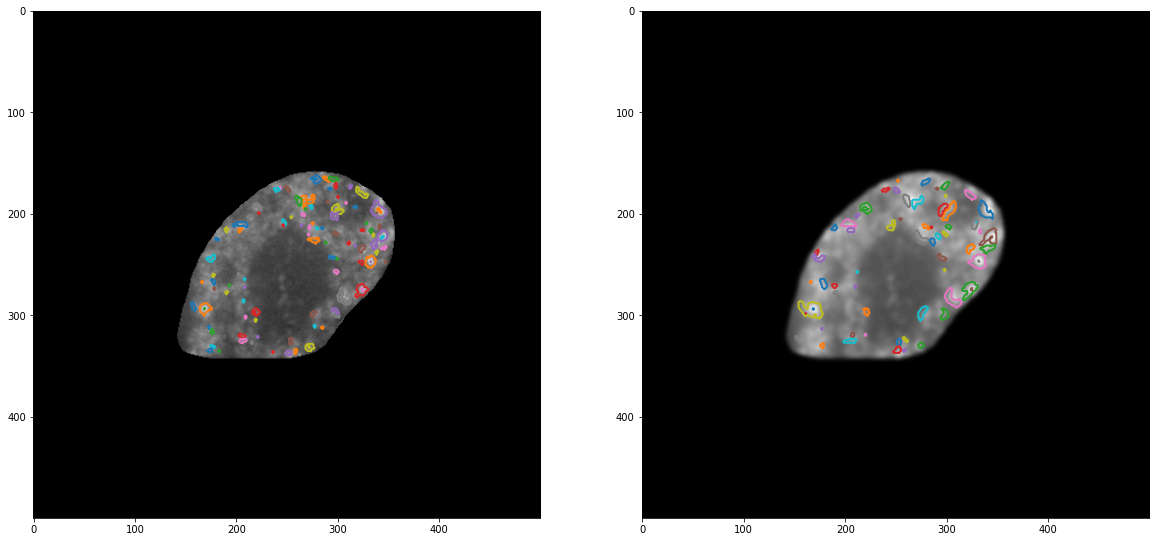

In [64]:
plt.figure(figsize=(20,20))
plt.subplot(1,2,1)
plt.imshow(image, cmap='gray')
for contour in cc_contours:
    plt.plot(contour[:, 1], contour[:, 0], linewidth=2)

plt.subplot(1,2,2)
plt.imshow(imagelr, cmap='gray')
for contour in cc_contourslr:
    plt.plot(contour[:, 1], contour[:, 0], linewidth=2)

In [107]:
import numpy as np
import cv2
from skimage import io, color, feature, filters, measure, segmentation
from skimage.feature import peak_local_max
from scipy import ndimage as ndi

def detect_chromocenters(image, proj_method='standard_deviation', enlarge=0, radius=3, fj_smooth=0.5, fj_int=3.0, min_chr=0.15, max_chr=0.5, scale_factor=1):
#     # 预处理图像
#     gray_image = color.rgb2gray(image)
#     inverted_image = 1 - gray_image
    
#     # 计算距离变换
#     distance = ndi.distance_transform_edt(inverted_image)
    
#     # 将标签转换为整数类型
#     labels = inverted_image.astype(np.int32)
    
#     local_maxi = peak_local_max(distance, min_distance=radius, labels=labels)
    
#     # 创建标记矩阵
#     markers = np.zeros_like(gray_image, dtype=np.int32)
#     for i, (row, col) in enumerate(local_maxi):
#         markers[row, col] = i + 1

#     # 分水岭分割
#     labels_ws = segmentation.watershed(-distance, markers, mask=inverted_image)
    labels_ws = image
    plt.imshow(labels_ws)
    plt.show()
    
    # 投影方法
    if proj_method == 'standard_deviation':
        proj_image = np.std(image, axis=-1)
    elif proj_method == 'max_intensity':
        proj_image = np.max(image, axis=-1)
    else:
        proj_image = image

    # 使用FeatureJ计算最大结构特征值
    smoothed_image = filters.gaussian(proj_image, sigma=fj_smooth)
    structure_tensor = feature.structure_tensor(smoothed_image, sigma=fj_int, order="rc")
    eigenvalues = feature.structure_tensor_eigenvalues(structure_tensor)
    largest_eigenvalue = np.max(eigenvalues, axis=0)
    
    # 打印调试信息
    print("Largest eigenvalue shape:", largest_eigenvalue.shape)

    # 阈值分割
    thresh = filters.threshold_otsu(largest_eigenvalue)
    print("Otsu threshold:", thresh)
    binary = largest_eigenvalue > thresh
    
    # 打印调试信息
    print("Binary image sum:", np.sum(binary))
    
    # 提取染色中心
    labels = measure.label(binary)
    props = measure.regionprops(labels)
    chromocenters = []
    for prop in props:
        area = prop.area * (scale_factor ** 2)
        if min_chr <= area <= max_chr:
            chromocenters.append(prop)
    
    return chromocenters

In [4]:
pip install matplotlib==3.4.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.9/37.9 MB 85.9 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
  Created wheel for matplotlib: filename=matplotlib-3.4.3-cp310-cp310-linux_x86_64.whl size=10682372 sha256=c91b747d4344671c163687b38f57661ebf59d8436cf4a3ad037c6795fa91484b
  Stored in directory: /home/acd13264yb/.cache/pip/wheels/71/af/e4/d399b616d3e7ae88374c2ebab2d5d3ecf776a3590d4f5f768f
Successfully built matplotlib
    tinycss2 (>=1.1.0<1.2) ; extra == 'css'
             ~~~~~~~~^
    numpy (>=1.18.1<=2.10.0)
          ~~~~~~~~~^
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.9.1
    Uninstalling matplotlib-3.9.1:
      Successfully uninstalled matplotlib-3.9.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dynamo-release 1.4.0 requires matplotlib>=3.5.3, but you have matplotlib 3.4.3 which is

In [3]:
import spateo as st

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /tmp/42640993.1.gpu/ipykernel_3814974/2274331556.py:1 in <cell line: 1>                          │
│                                                                                                  │
│ [Errno 2] No such file or directory: '/tmp/42640993.1.gpu/ipykernel_3814974/2274331556.py'       │
│                                                                                                  │
│ /home/acd13264yb/python10_env/lib/python3.10/site-packages/spateo/__init__.py:9 in <module>      │
│                                                                                                  │
│    6 __version__ = get_version(__file__)                                                         │
│    7 del get_version                                                                             │
│    8                                                                                             │
│ ❱  9 from . import cs, dd, io, pl, pp, sample_data, tdr, tl                                      │
│   10 from .configuration import config                                                           │
│   11 from .data_io import *                                                                      │
│   12                                                                                             │
│                                                                                                  │
│ /home/acd13264yb/python10_env/lib/python3.10/site-packages/spateo/cs.py:1 in <module>            │
│                                                                                                  │
│ ❱ 1 from .segmentation import *                                                                  │
│   2                                                                                              │
│                                                                                                  │
│ /home/acd13264yb/python10_env/lib/python3.10/site-packages/spateo/segmentation/__init__.py:3 in  │
│ <module>                                                                                         │
│                                                                                                  │
│    1 """Spatiotemporal modeling of spatial transcriptomics                                       │
│    2 """                                                                                         │
│ ❱  3 from . import (                                                                             │
│    4 │   align,                                                                                  │
│    5 │   benchmark,                                                                              │
│    6 │   bp,                                                                                     │
│                                                                                                  │
│ /home/acd13264yb/python10_env/lib/python3.10/site-packages/spateo/segmentation/align.py:16 in    │
│ <module>                                                                                         │
│                                                                                                  │
│    13 from tqdm import tqdm                                                                      │
│    14 from typing_extensions import Literal                                                      │
│    15                                                                                            │
│ ❱  16 from ..configuration import SKM                                                            │
│    17 from ..errors import SegmentationError                                                     │
│    18 from ..logging import logger_manager as lm                                                 │
│    19 from . import utils                                  

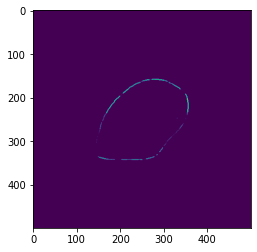

ValueError: The parameter `image` must be a 2-or-3-or-4-or-5-dimensional array

In [108]:
# 示例图像（假设你已经加载了图像）
image = np.load(f"{home_path}/Datasets/{image_path}.npy", allow_pickle=True)[5]

# 检测染色中心
chromocenters = detect_chromocenters(cc_mask)
chromocenters
# # 可视化结果
# output_image = image.copy()
# for cc in chromocenters:
#     minr, minc, maxr, maxc = cc.bbox
#     cv2.rectangle(output_image, (minc, minr), (maxc, maxr), (0, 255, 0), 2)

# plt.imshow(output_image)
# plt.show()

In [52]:
ctrl_type = "RETT"
chip_type = "CTCF"
image_path = f"{ctrl_type}_{rett_type}_{chip_type}"

cam = np.load(f"{home_path}/results_cam/{ctrl_type}_{chip_type}_Resnet10_noavg_ScoreCAM/{ctrl_type}_{chip_type}_Resnet10_noavg_ScoreCAM_cam.npy", allow_pickle=True)
print(cam.shape)
img = np.load(f"{home_path}/results_cam/{ctrl_type}_{chip_type}_Resnet10_noavg_ScoreCAM/{ctrl_type}_{chip_type}_Resnet10_noavg_ScoreCAM_img.npy", allow_pickle=True)
print(img.shape)

(3518, 500, 500)
(3518, 500, 500, 3)


Calculate_quantitative_metrics:
number_of_cc: 19
nuclear_area: 44940
heterochromatin_fraction: 0.010970182465509569
relative_heterochromatin_intensity: 1.9389634132385254
relative_heterochromatin_fraction: 0.021270782437173855
Calculate_quantitative_metrics:
number_of_cc: 205
nuclear_area: 44940
heterochromatin_fraction: 0.09568313306631064
relative_heterochromatin_intensity: 1.1363294124603271
relative_heterochromatin_fraction: 0.10872755837960407
Calculate_quantitative_metrics:
number_of_cc: 19
nuclear_area: 44940
heterochromatin_fraction: 0.010970182465509569
relative_heterochromatin_intensity: 1.9389634132385254
relative_heterochromatin_fraction: 0.021270782437173855


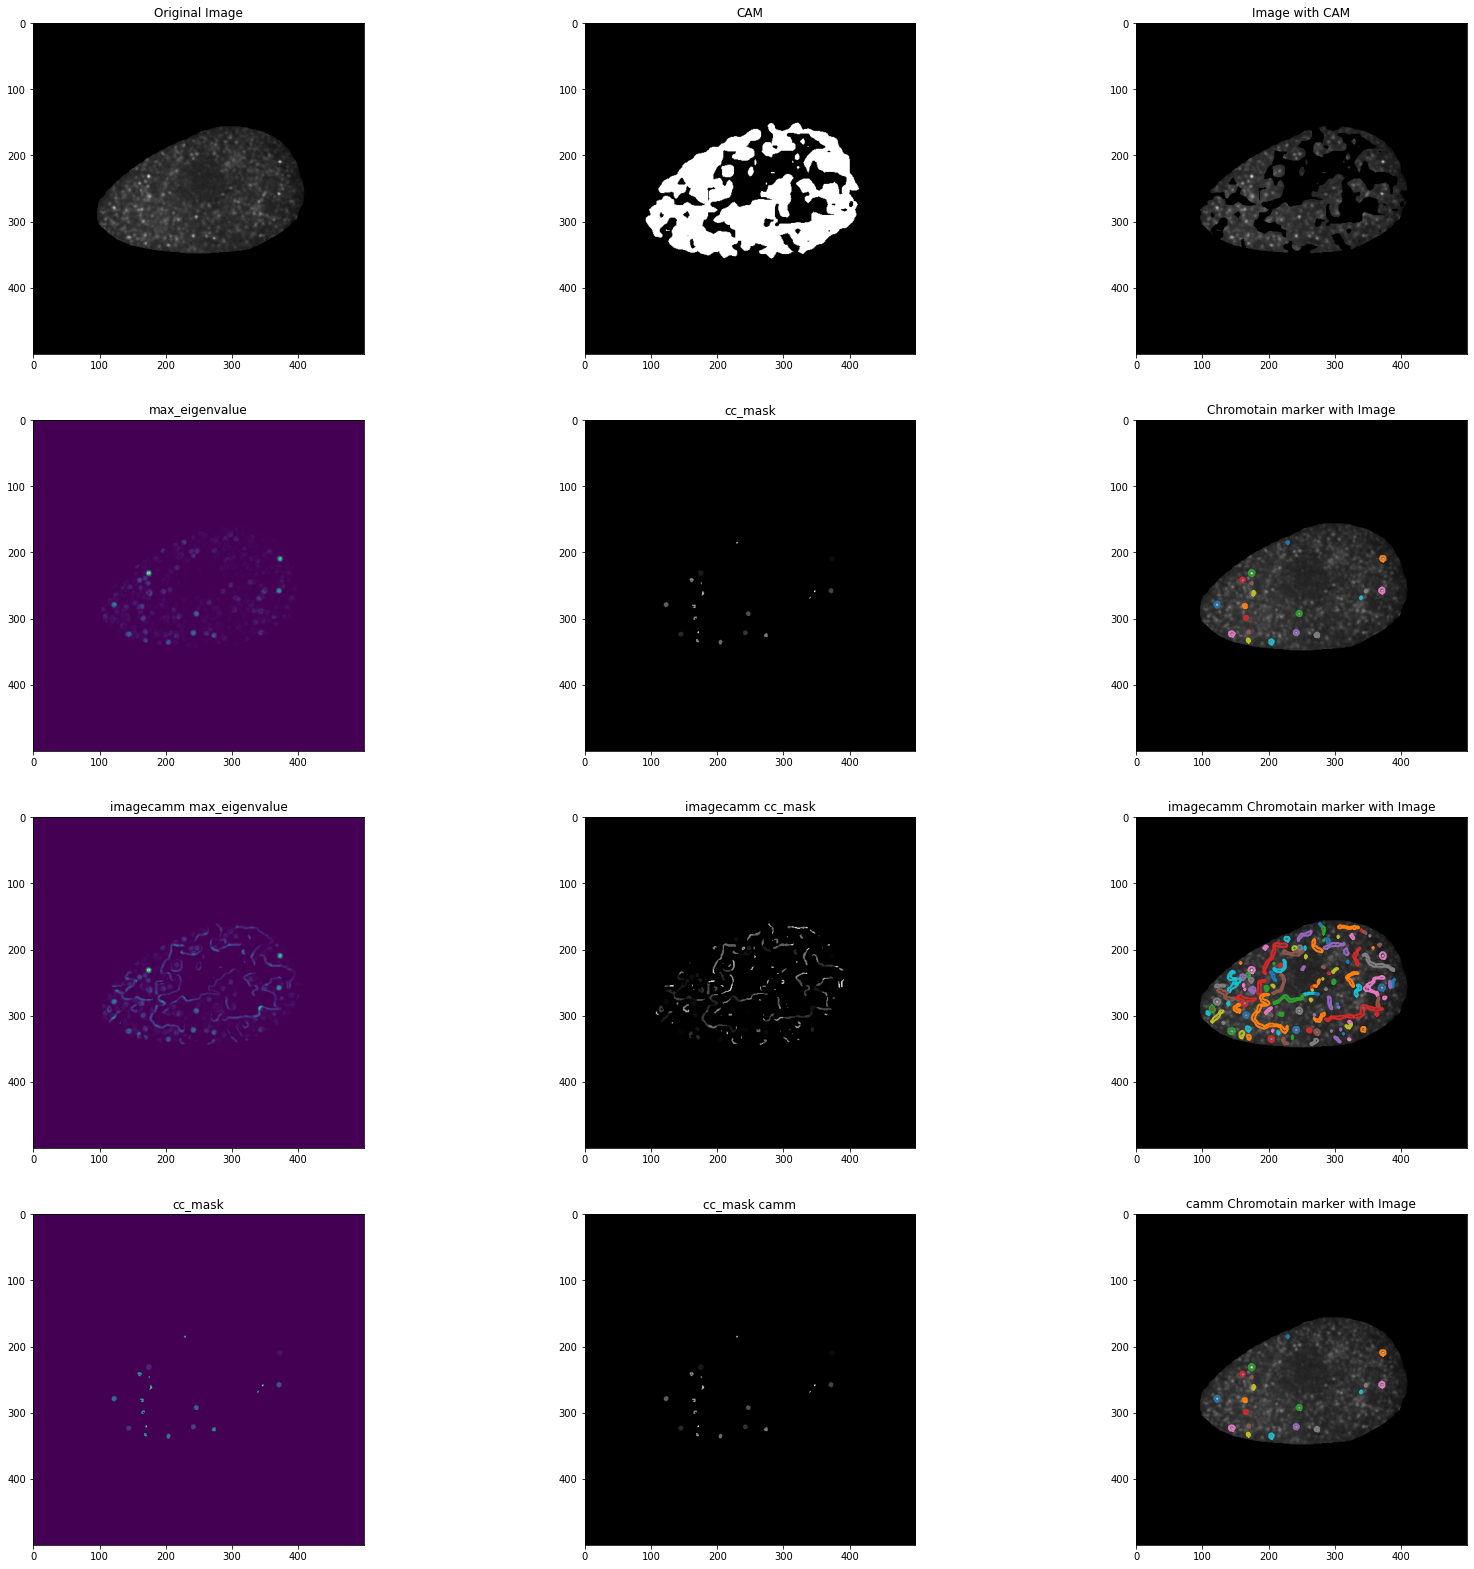

In [56]:
n = len(image)-1
n = 5
x, y = 4, 3

image = img[n,:,:,0]
camm = cam[n,:,:]
camm = camm > threshold_otsu(camm)
# camm = camm > 0.2
plt.figure(figsize=(28,28))
plt.subplot(x,y,1)
plt.title("Original Image")
plt.imshow(image, cmap='gray')
plt.subplot(x,y,2)
plt.title("CAM")
plt.imshow(camm, cmap='gray')
imagecamm = image * camm
plt.subplot(x,y,3)
plt.title("Image with CAM")
plt.imshow(imagecamm, cmap='gray')



# Extract particle (Heterochromatin)
max_eigenvalue = compute_largest_eigenvalue(image, sigma=1)
plt.subplot(x,y,4)
plt.title("max_eigenvalue")
plt.imshow(max_eigenvalue)
cc_mask = apply_h_watershed(max_eigenvalue, min_distance=5)
plt.subplot(x,y,5)
plt.title("cc_mask")
plt.imshow(cc_mask, cmap='gray')

# Metrics particle (Heterochromatin)
metrics = calculate_quantitative_metrics(image, cc_mask)
print("Calculate_quantitative_metrics:")
for key, value in metrics.items():
    print(f"{key}: {value}")

cc_contours = find_contours(cc_mask, level=0.5)
plt.subplot(x,y,6)
plt.title("Chromotain marker with Image")
plt.imshow(image, cmap='gray')
for contour in cc_contours:
    plt.plot(contour[:, 1], contour[:, 0], linewidth=2)


image = img[n,:,:,0]
# Extract particle (Heterochromatin)
max_eigenvalue = compute_largest_eigenvalue(imagecamm, sigma=1)
plt.subplot(x,y,7)
plt.title("imagecamm max_eigenvalue")
plt.imshow(max_eigenvalue)
cc_mask = apply_h_watershed(max_eigenvalue, min_distance=5)
plt.subplot(x,y,8)
plt.title("imagecamm cc_mask")
plt.imshow(cc_mask, cmap='gray')

# Metrics particle (Heterochromatin)
metrics = calculate_quantitative_metrics(image, cc_mask)
print("Calculate_quantitative_metrics:")
for key, value in metrics.items():
    print(f"{key}: {value}")

cc_contours = find_contours(cc_mask, level=0.5)
plt.subplot(x,y,9)
plt.title("imagecamm Chromotain marker with Image")
plt.imshow(image, cmap='gray')
for contour in cc_contours:
    plt.plot(contour[:, 1], contour[:, 0], linewidth=2)

    
image = img[n,:,:,0]
# Extract particle (Heterochromatin)
max_eigenvalue = compute_largest_eigenvalue(image, sigma=1)
cc_mask = apply_h_watershed(max_eigenvalue, min_distance=5)
plt.subplot(x,y,10)
plt.title("cc_mask")
plt.imshow(cc_mask)

cc_mask = cc_mask*camm
plt.subplot(x,y,11)
plt.title("cc_mask camm")
plt.imshow(cc_mask, cmap='gray')

# Metrics particle (Heterochromatin)
metrics = calculate_quantitative_metrics(image, cc_mask)
print("Calculate_quantitative_metrics:")
for key, value in metrics.items():
    print(f"{key}: {value}")

cc_contours = find_contours(cc_mask, level=0.5)
plt.subplot(x,y,12)
plt.title("camm Chromotain marker with Image")
plt.imshow(image, cmap='gray')
for contour in cc_contours:
    plt.plot(contour[:, 1], contour[:, 0], linewidth=2)
plt.show()

# RETT

🧶 Calculate_quantitative_metrics:
chromatin_num: 290
nuclear_area: 42664
chromatin_area: 18.517241379310345
RCA-S: 0.1258672417026064
RCA-M: 0.000434024971388298
nuclear_intensity: 40.19529345584099
chromatin_intensity: 40.69275398516506
RCI-S: 293.5890658109629
RCI-M: 1.0123760890033204
🧶 LR Calculate_quantitative_metrics:
chromatin_num: 74
nuclear_area: 45913
chromatin_area: 32.932432432432435
RCA-S: 0.053078648748720404
RCA-M: 0.0007172790371448704
nuclear_intensity: 37.34661207065537
chromatin_intensity: 44.22931754833101
RCI-S: 87.63765485298704
RCI-M: 1.1842926331484736


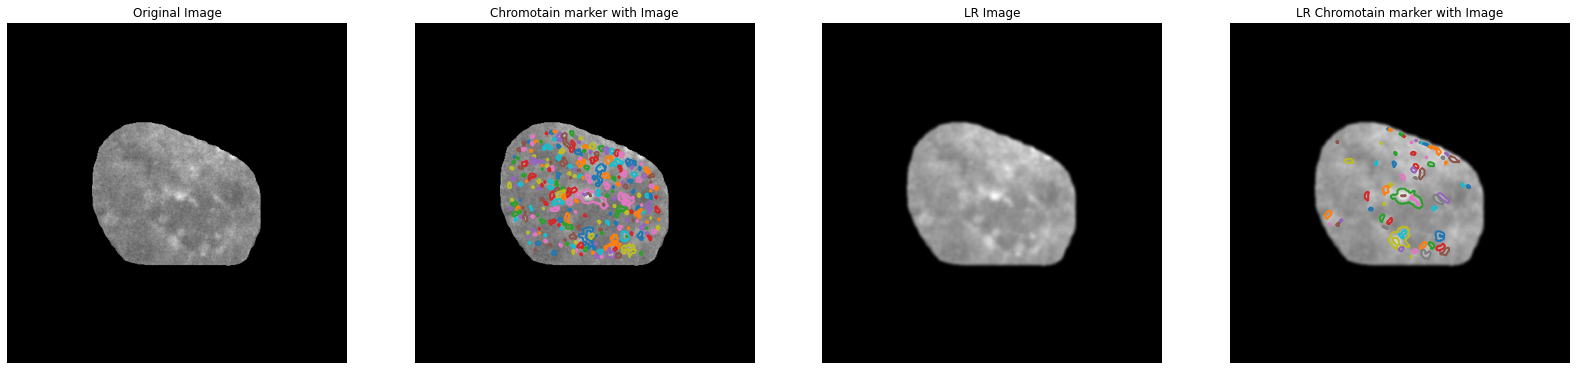

🧶 Calculate_quantitative_metrics:
chromatin_num: 289
nuclear_area: 55378
chromatin_area: 16.55017301038062
RCA-S: 0.08637003864350463
RCA-M: 0.0002988582652024382
nuclear_intensity: 34.24497092708296
chromatin_intensity: 36.36332330941088
RCI-S: 306.87718961117884
RCI-M: 1.0618587875819336
🧶 LR Calculate_quantitative_metrics:
chromatin_num: 20
nuclear_area: 59063
chromatin_area: 73.7
RCA-S: 0.024956402485481605
RCA-M: 0.0012478201242740804
nuclear_intensity: 32.10651338401368
chromatin_intensity: 42.73825315030901
RCI-S: 26.622793100660402
RCI-M: 1.3311396550330201


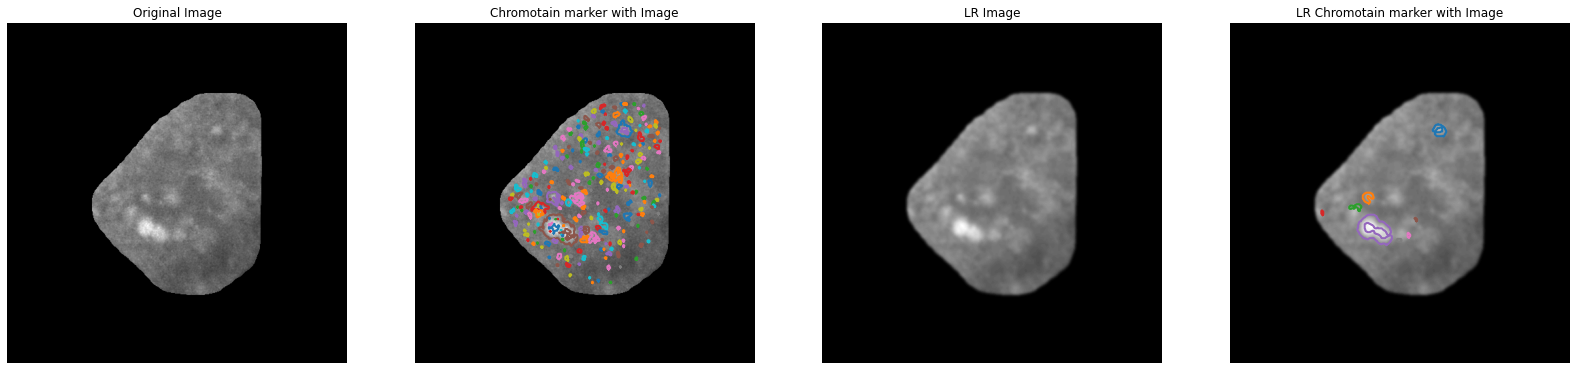

🧶 Calculate_quantitative_metrics:
chromatin_num: 219
nuclear_area: 56019
chromatin_area: 21.136986301369863
RCA-S: 0.08263267819846838
RCA-M: 0.0003773181652898099
nuclear_intensity: 20.20353808529249
chromatin_intensity: 24.41970652090406
RCI-S: 264.7019401008329
RCI-M: 1.2086846579946708
🧶 LR Calculate_quantitative_metrics:
chromatin_num: 59
nuclear_area: 59405
chromatin_area: 25.796610169491526
RCA-S: 0.025620738995034087
RCA-M: 0.00043424981347515404
nuclear_intensity: 19.049995791600033
chromatin_intensity: 28.906785974010013
RCI-S: 89.52759838501485
RCI-M: 1.5174169217799127


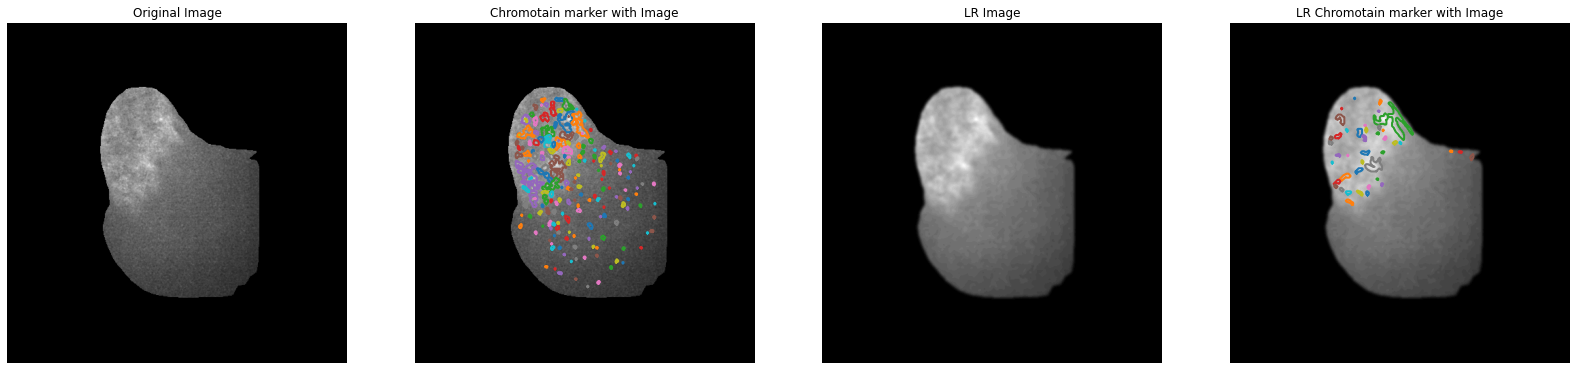

🧶 Calculate_quantitative_metrics:
chromatin_num: 380
nuclear_area: 96762
chromatin_area: 13.157894736842104
RCA-S: 0.051673177487030035
RCA-M: 0.0001359820460185001
nuclear_intensity: 16.93975940968562
chromatin_intensity: 18.952567167555127
RCI-S: 425.1521730322265
RCI-M: 1.1188215079795434
🧶 LR Calculate_quantitative_metrics:
chromatin_num: 6
nuclear_area: 100992
chromatin_area: 47.333333333333336
RCA-S: 0.002812103929024081
RCA-M: 0.0004686839881706802
nuclear_intensity: 16.228839908111535
chromatin_intensity: 25.44442861052467
RCI-S: 9.407115513342509
RCI-M: 1.5678525855570846


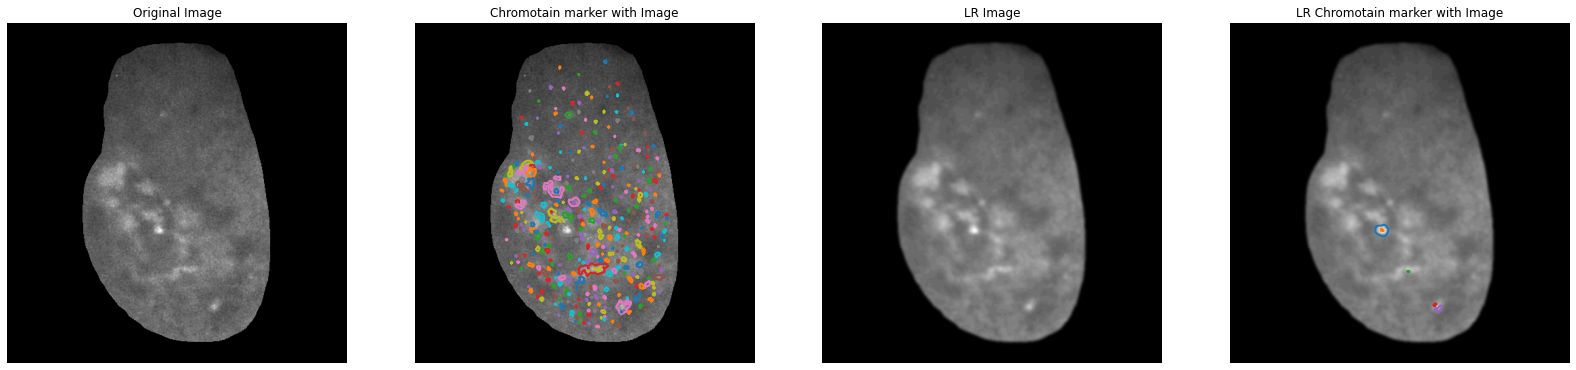

🧶 Calculate_quantitative_metrics:
chromatin_num: 147
nuclear_area: 26646
chromatin_area: 60.06802721088435
RCA-S: 0.33138182091120616
RCA-M: 0.0022542981014367766
nuclear_intensity: 3.2460406815281844
chromatin_intensity: 3.2790755211734437
RCI-S: 148.49601373004572
RCI-M: 1.010176964149971
🧶 LR Calculate_quantitative_metrics:
chromatin_num: 137
nuclear_area: 27791
chromatin_area: 29.197080291970803
RCA-S: 0.14393148861142097
RCA-M: 0.0010505948073826347
nuclear_intensity: 3.100716059155842
chromatin_intensity: 3.423468529353615
RCI-S: 151.26028297126078
RCI-M: 1.1040896567245313


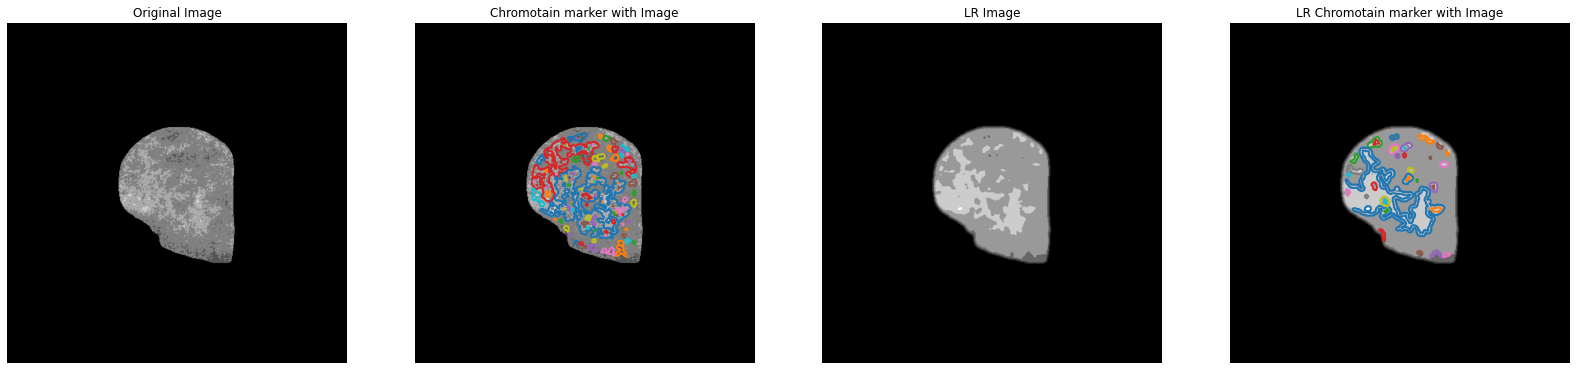

In [34]:
ctrl_type = "RETT"
rett_type = "HPS9999"
chip_type = "Dapi"
image_path = f"{ctrl_type}_{rett_type}_{chip_type}"
data = np.load(f"{home_path}/Datasets/{image_path}.npy", allow_pickle=True)
dataLR = np.load(f"{home_path}/Datasets_LR/{image_path}.npy", allow_pickle=True)

for num in range(5):
    image = data[num,:,:,0]
    plt.figure(figsize=(28,28))
    plt.subplot(1,4,1)
    plt.title("Original Image")
    plt.axis("off")
    plt.imshow(image, cmap='gray')

    # Extract particle (chromatin)
    max_eigenvalue = compute_largest_eigenvalue(image, sigma=1, pad_width=25)
    cc_mask = apply_h_watershed(max_eigenvalue, min_distance=5)
    
    # Metrics particle (chromatin)
    metrics = calculate_quantitative_metrics(image, cc_mask)
    print("🧶 Calculate_quantitative_metrics:")
    for key, value in metrics.items():
        print(f"{key}: {value}")
        
    cc_contours = find_contours(cc_mask, level=0.5)
    plt.subplot(1,4,2)
    plt.title("Chromotain marker with Image")
    plt.axis("off")
    plt.imshow(image, cmap='gray')
    for contour in cc_contours:
        plt.plot(contour[:, 1], contour[:, 0], linewidth=2)

        
        
    imageLR = dataLR[num,:,:,0]
    plt.subplot(1,4,3)
    plt.title("LR Image")
    plt.axis("off")
    plt.imshow(imageLR, cmap='gray')
    # Extract particle (chromatin)
    max_eigenvalue = compute_largest_eigenvalue(imageLR, sigma=1, pad_width=25)
    cc_mask = apply_h_watershed(max_eigenvalue, min_distance=5)
    
    # Metrics particle (chromatin)
    metrics = calculate_quantitative_metrics(imageLR, cc_mask)
    print("🧶 LR Calculate_quantitative_metrics:")
    for key, value in metrics.items():
        print(f"{key}: {value}")
        
    cc_contours = find_contours(cc_mask, level=0.5)
    plt.subplot(1,4,4)
    plt.title("LR Chromotain marker with Image")
    plt.axis("off")
    plt.imshow(imageLR, cmap='gray')
    for contour in cc_contours:
        plt.plot(contour[:, 1], contour[:, 0], linewidth=2)
    plt.show()

🧶 Calculate_quantitative_metrics:
chromatin_num: 70
nuclear_area: 46257
chromatin_area: 20.714285714285715
RCA-S: 0.03134660700002162
RCA-M: 0.0004478086714288803
nuclear_intensity: 27.994054953844824
chromatin_intensity: 39.93763636402263
RCI-S: 99.86529461669217
RCI-M: 1.4266470659527453
🧶 LR Calculate_quantitative_metrics:
chromatin_num: 108
nuclear_area: 49376
chromatin_area: 29.77777777777778
RCA-S: 0.06513285806869734
RCA-M: 0.000603082019154605
nuclear_intensity: 26.222436001296177
chromatin_intensity: 34.159764404821196
RCI-S: 140.69076402887697
RCI-M: 1.3026922595266388


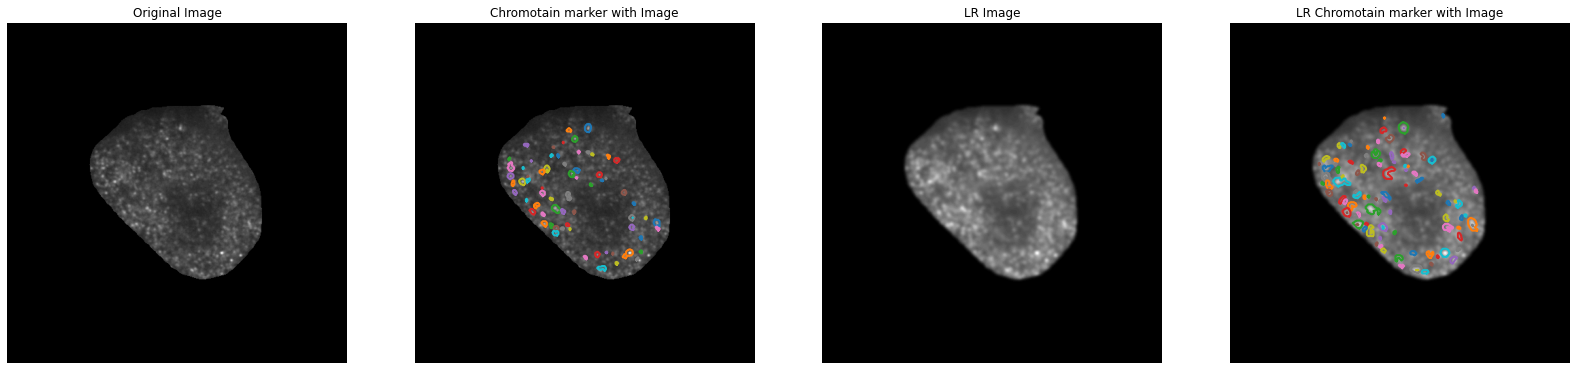

🧶 Calculate_quantitative_metrics:
chromatin_num: 144
nuclear_area: 45056
chromatin_area: 21.77777777777778
RCA-S: 0.06960227272727272
RCA-M: 0.0004833491161616162
nuclear_intensity: 69.83615944602273
chromatin_intensity: 89.7738760382368
RCI-S: 185.11095472679713
RCI-M: 1.2854927411583135
🧶 LR Calculate_quantitative_metrics:
chromatin_num: 143
nuclear_area: 48466
chromatin_area: 33.05594405594405
RCA-S: 0.09753229067800108
RCA-M: 0.0006820439907552522
nuclear_intensity: 64.91835513555895
chromatin_intensity: 80.36942146430938
RCI-S: 177.03509655162318
RCI-M: 1.238007668193169


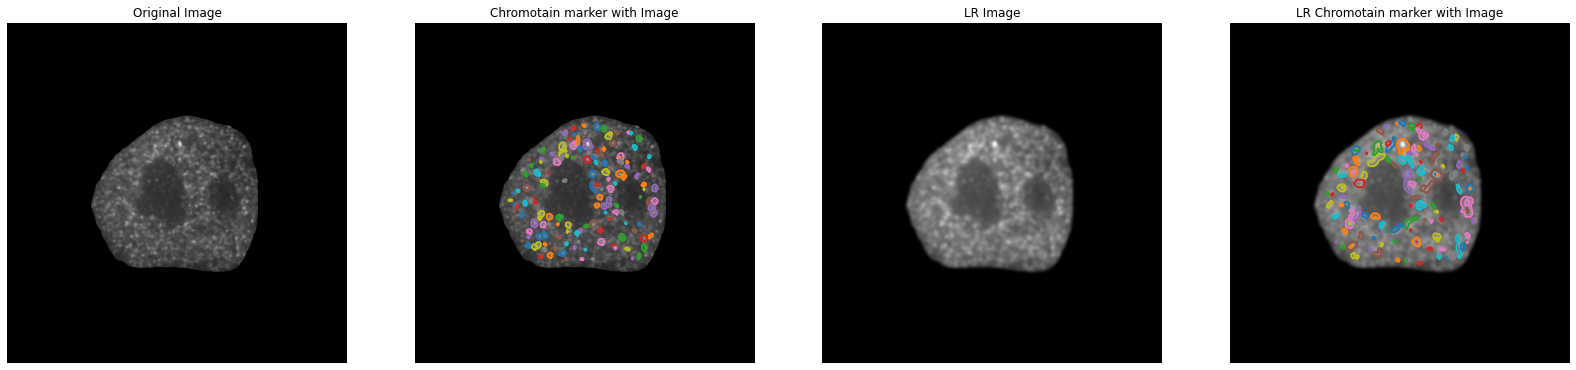

🧶 Calculate_quantitative_metrics:
chromatin_num: 47
nuclear_area: 47215
chromatin_area: 19.361702127659573
RCA-S: 0.01927353595255745
RCA-M: 0.0004100752330331372
nuclear_intensity: 60.05959970348406
chromatin_intensity: 89.4914067918723
RCI-S: 70.03203717613192
RCI-M: 1.4900433441730196
🧶 LR Calculate_quantitative_metrics:
chromatin_num: 93
nuclear_area: 50694
chromatin_area: 32.505376344086024
RCA-S: 0.05963230362567562
RCA-M: 0.0006412075658674798
nuclear_intensity: 55.935021896082375
chromatin_intensity: 74.00270051121514
RCI-S: 123.04010822287766
RCI-M: 1.3230119163750287


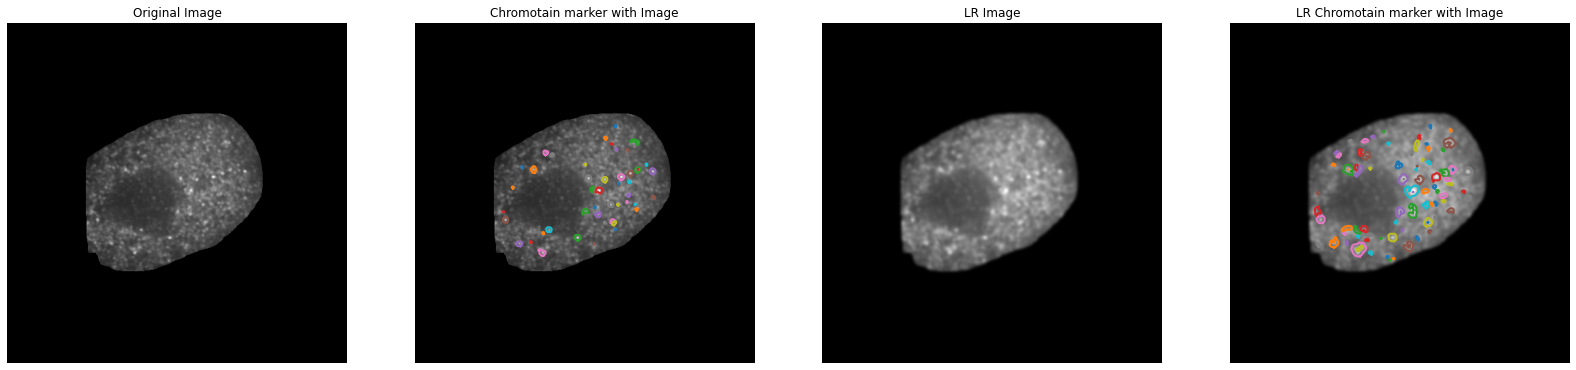

🧶 Calculate_quantitative_metrics:
chromatin_num: 93
nuclear_area: 38701
chromatin_area: 19.903225806451612
RCA-S: 0.04782822149298468
RCA-M: 0.0005142819515374696
nuclear_intensity: 75.0738740601018
chromatin_intensity: 100.56686880059455
RCI-S: 124.58020736971424
RCI-M: 1.339572122254992
🧶 LR Calculate_quantitative_metrics:
chromatin_num: 134
nuclear_area: 41947
chromatin_area: 34.02238805970149
RCA-S: 0.10868476887500894
RCA-M: 0.0008110803647388726
nuclear_intensity: 69.2629270269626
chromatin_intensity: 86.78586589031708
RCI-S: 167.90087465947613
RCI-M: 1.252991601936389


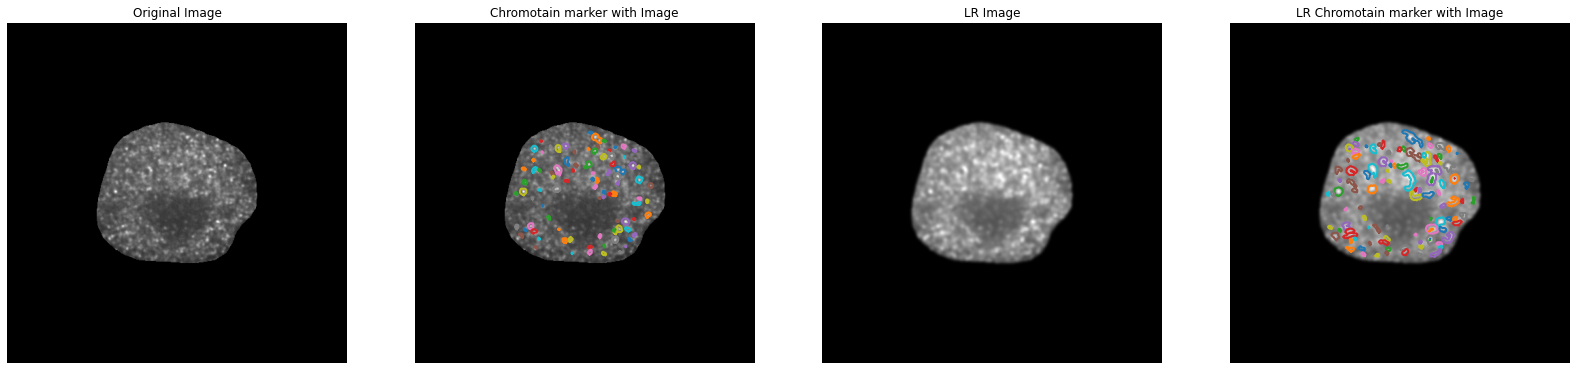

🧶 Calculate_quantitative_metrics:
chromatin_num: 110
nuclear_area: 44118
chromatin_area: 23.854545454545455
RCA-S: 0.05947685751847318
RCA-M: 0.0005406987047133926
nuclear_intensity: 69.99911600707195
chromatin_intensity: 94.8176456663489
RCI-S: 149.00103913090348
RCI-M: 1.3545549011900315
🧶 LR Calculate_quantitative_metrics:
chromatin_num: 151
nuclear_area: 47447
chromatin_area: 30.205298013245034
RCA-S: 0.09612831158977385
RCA-M: 0.0006366113350316149
nuclear_intensity: 65.08556916138006
chromatin_intensity: 80.76825138962107
RCI-S: 187.38417927317667
RCI-M: 1.2409548296236865


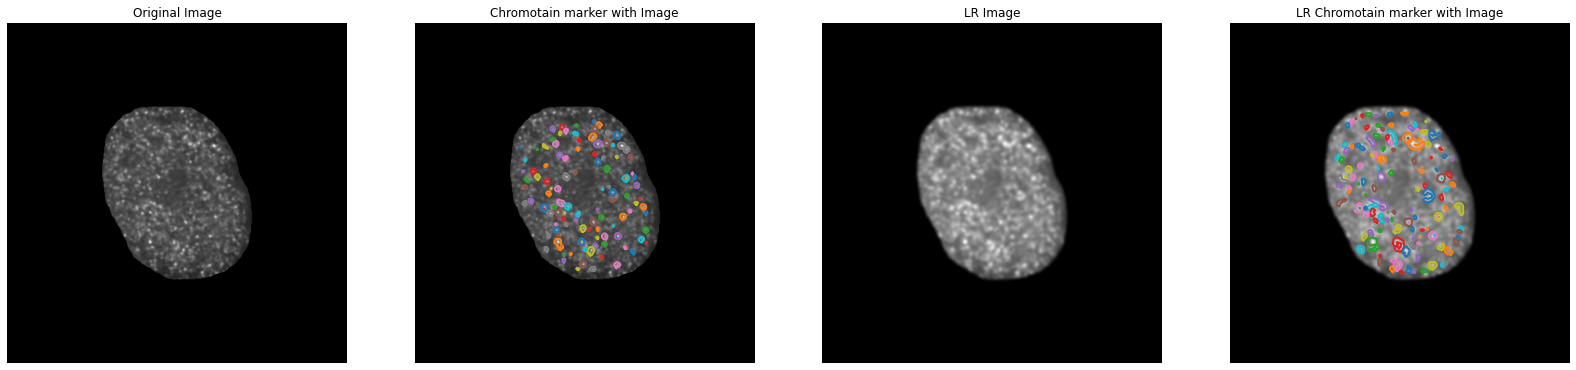

In [32]:
ctrl_type = "CTRL"
chip_type = "CTCF"
image_path = f"{ctrl_type}_{chip_type}"
data = np.load(f"{home_path}/Datasets/{image_path}.npy", allow_pickle=True)
dataLR = np.load(f"{home_path}/Datasets_LR/{image_path}.npy", allow_pickle=True)

for num in range(15,20):
    image = data[num,:,:,0]
    plt.figure(figsize=(28,28))
    plt.subplot(1,4,1)
    plt.title("Original Image")
    plt.axis("off")
    plt.imshow(image, cmap='gray')

    # Extract particle (Heterochromatin)
    max_eigenvalue = compute_largest_eigenvalue(image, sigma=1, pad_width=25)
    cc_mask = apply_h_watershed(max_eigenvalue, min_distance=5)
    
    # Metrics particle (Heterochromatin)
    metrics = calculate_quantitative_metrics(image, cc_mask)
    print("🧶 Calculate_quantitative_metrics:")
    for key, value in metrics.items():
        print(f"{key}: {value}")
        
    cc_contours = find_contours(cc_mask, level=0.5)
    plt.subplot(1,4,2)
    plt.title("Chromotain marker with Image")
    plt.axis("off")
    plt.imshow(image, cmap='gray')
    for contour in cc_contours:
        plt.plot(contour[:, 1], contour[:, 0], linewidth=2)

        
        
    imageLR = dataLR[num,:,:,0]
    plt.subplot(1,4,3)
    plt.title("LR Image")
    plt.axis("off")
    plt.imshow(imageLR, cmap='gray')
    # Extract particle (Heterochromatin)
    max_eigenvalue = compute_largest_eigenvalue(imageLR, sigma=1, pad_width=25)
    cc_mask = apply_h_watershed(max_eigenvalue, min_distance=5)
    
    # Metrics particle (Heterochromatin)
    metrics = calculate_quantitative_metrics(imageLR, cc_mask)
    print("🧶 LR Calculate_quantitative_metrics:")
    for key, value in metrics.items():
        print(f"{key}: {value}")
        
    cc_contours = find_contours(cc_mask, level=0.5)
    plt.subplot(1,4,4)
    plt.title("LR Chromotain marker with Image")
    plt.axis("off")
    plt.imshow(imageLR, cmap='gray')
    for contour in cc_contours:
        plt.plot(contour[:, 1], contour[:, 0], linewidth=2)
    plt.show()

# Extract All

In [58]:
home_path = "/groups/4/gaa50089/acd13264yb/Rettsyndrome/Classification"
save_path = "/groups/4/gaa50089/acd13264yb/Rettsyndrome/Biomarker"
# chip_type = "H3K27ac"

for chip_type in ["CTCF", "Dapi"]:
    ctrl_type = "RETT"
    total_results = {}
    for rett_type in ["HPS3042", "HPS3049", "HPS3084", "HPS9999"]:
        image_path = f"{ctrl_type}_{rett_type}_{chip_type}"
        data = np.load(f"{home_path}/Datasets/{image_path}.npy", allow_pickle=True)
        print(f"load {image_path}")
        results = []

        for i in tqdm(range(len(data))):
            image = data[i, :, :, 0]

            max_eigenvalue = compute_largest_eigenvalue(image, sigma=1)
            cc_mask = apply_h_watershed(max_eigenvalue, min_distance=5)
            metrics = calculate_quantitative_metrics(image, cc_mask)

            # 将metrics字典转换为一行
            result_row = {
                'number_of_cc': metrics['number_of_cc'],
                'nuclear_area': metrics['nuclear_area'],
                'heterochromatin_fraction': metrics['heterochromatin_fraction'],
                'relative_heterochromatin_intensity': metrics['relative_heterochromatin_intensity'],
                'relative_heterochromatin_fraction': metrics['relative_heterochromatin_fraction']
            }

            results.append(result_row)

        # 创建DataFrame
        df = pd.DataFrame(results)
        total_results[image_path] = df

        # 保存DataFrame到文件
        df.to_csv(f"{save_path}/tables/features_heterochromatin/{image_path}.csv", index=False)

    ctrl_type = "CTRL"
    image_path = f"{ctrl_type}_{chip_type}"
    data = np.load(f"{home_path}/Datasets/{image_path}.npy", allow_pickle=True)
    print(f"load {image_path}")
    results = []
    for i in tqdm(range(len(data))):
        image = data[i, :, :, 0]

        max_eigenvalue = compute_largest_eigenvalue(image, sigma=1)
        cc_mask = apply_h_watershed(max_eigenvalue, min_distance=5)
        metrics = calculate_quantitative_metrics(image, cc_mask)

        result_row = {
            'number_of_cc': metrics['number_of_cc'],
            'nuclear_area': metrics['nuclear_area'],
            'heterochromatin_fraction': metrics['heterochromatin_fraction'],
            'relative_heterochromatin_intensity': metrics['relative_heterochromatin_intensity'],
            'relative_heterochromatin_fraction': metrics['relative_heterochromatin_fraction']
        }

        results.append(result_row)

    # 创建DataFrame
    df = pd.DataFrame(results)
    total_results[image_path] = df

    # 保存DataFrame到文件
    df.to_csv(f"{save_path}/tables/features_heterochromatin/{image_path}.csv", index=False)

load RETT_HPS3042_CTCF


100%|████████████████████████████████████████████████████████| 905/905 [01:35<00:00,  9.45it/s]


load RETT_HPS3049_CTCF


100%|██████████████████████████████████████████████████████| 1358/1358 [02:44<00:00,  8.24it/s]


load RETT_HPS3084_CTCF


100%|██████████████████████████████████████████████████████| 1332/1332 [01:41<00:00, 13.17it/s]


load RETT_HPS9999_CTCF


100%|██████████████████████████████████████████████████████| 3595/3595 [06:03<00:00,  9.88it/s]


load CTRL_CTCF


100%|██████████████████████████████████████████████████████| 1723/1723 [03:24<00:00,  8.44it/s]


load RETT_HPS3042_Dapi


100%|████████████████████████████████████████████████████████| 905/905 [02:18<00:00,  6.55it/s]


load RETT_HPS3049_Dapi


100%|██████████████████████████████████████████████████████| 1358/1358 [03:43<00:00,  6.08it/s]


load RETT_HPS3084_Dapi


100%|██████████████████████████████████████████████████████| 1332/1332 [03:23<00:00,  6.55it/s]


load RETT_HPS9999_Dapi


100%|██████████████████████████████████████████████████████| 3595/3595 [09:41<00:00,  6.18it/s]


load CTRL_Dapi


100%|██████████████████████████████████████████████████████| 1723/1723 [04:27<00:00,  6.43it/s]


In [62]:
home_path = "/groups/4/gaa50089/acd13264yb/Rettsyndrome/Classification"
save_path = "/groups/4/gaa50089/acd13264yb/Rettsyndrome/Biomarker"
# chip_type = "H3K27ac"

for chip_type in ["H3K27ac", "CTCF", "Dapi"]:
    total_results = {}
    for ctrl_type in ["RETT", "CTRL"]:
        image_path = f"{ctrl_type}_{chip_type}"
        cam = np.load(f"{home_path}/results_cam/{image_path}_Resnet10_noavg_ScoreCAM/{image_path}_Resnet10_noavg_ScoreCAM_cam.npy", allow_pickle=True)
        print(f"{ctrl_type}_{chip_type} cam", cam.shape)
        img = np.load(f"{home_path}/results_cam/{image_path}_Resnet10_noavg_ScoreCAM/{image_path}_Resnet10_noavg_ScoreCAM_img.npy", allow_pickle=True)
        print(f"{ctrl_type}_{chip_type} img", img.shape)
        if len(img)!=len(cam): 
            print("len(img)!=len(cam) break")
            break
            
        results = []
        for n in tqdm(range(len(img))):
            image = img[n,:,:,0]
            camm = cam[n,:,:]
            camm = camm > threshold_otsu(camm)

            max_eigenvalue = compute_largest_eigenvalue(image, sigma=1)
            cc_mask = apply_h_watershed(max_eigenvalue, min_distance=5) * camm
            metrics = calculate_quantitative_metrics(image, cc_mask)

            # 将metrics字典转换为一行
            result_row = {
                'number_of_cc': metrics['number_of_cc'],
                'nuclear_area': metrics['nuclear_area'],
                'heterochromatin_fraction': metrics['heterochromatin_fraction'],
                'relative_heterochromatin_intensity': metrics['relative_heterochromatin_intensity'],
                'relative_heterochromatin_fraction': metrics['relative_heterochromatin_fraction']
            }

            results.append(result_row)

        # 创建DataFrame
        df = pd.DataFrame(results)
        total_results[image_path] = df

        # 保存DataFrame到文件
        df.to_csv(f"{save_path}/tables/features_chromatinCAM/{image_path}.csv", index=False)


RETT_H3K27ac cam (3486, 500, 500)
RETT_H3K27ac img (3486, 500, 500, 3)


100%|███████████████████████████████████████████████████████████████████| 3486/3486 [05:54<00:00,  9.84it/s]


CTRL_H3K27ac cam (1567, 500, 500)
CTRL_H3K27ac img (1567, 500, 500, 3)


100%|█████████████████████████████████████████████████████████████████████████████████████| 1567/1567 [02:28<00:00, 10.56it/s]


RETT_CTCF cam (3518, 500, 500)
RETT_CTCF img (3518, 500, 500, 3)


100%|█████████████████████████████████████████████████████████████████████████████████████| 3518/3518 [05:13<00:00, 11.23it/s]


CTRL_CTCF cam (1592, 500, 500)
CTRL_CTCF img (1592, 500, 500, 3)


  5%|████▍                                                                                  | 81/1592 [00:08<02:30, 10.04it/s]/home/acd13264yb/python10_env/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/acd13264yb/python10_env/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|█████████████████████████████████████████████████████████████████████████████████████| 1592/1592 [02:36<00:00, 10.18it/s]


RETT_Dapi cam (3484, 500, 500)
RETT_Dapi img (3484, 500, 500, 3)


100%|█████████████████████████████████████████████████████████████████████████████████████| 3484/3484 [07:52<00:00,  7.38it/s]


CTRL_Dapi cam (1517, 500, 500)
CTRL_Dapi img (1517, 500, 500, 3)


100%|█████████████████████████████████████████████████████████████████████████████████████| 1517/1517 [03:45<00:00,  6.73it/s]
